In [407]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, average_precision_score
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             RocCurveDisplay, 
                             roc_curve, 
                             auc)
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (precision_recall_curve,
                             PrecisionRecallDisplay)
from scipy.stats import chi2_contingency

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score




### 01. Data Loading & Basic Inspection

In [408]:
df = pd.read_csv("data/adult.csv")

In [332]:
print(df.info())
print("--------------------------")
print(df['income'].value_counts(dropna=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
--------------------------
income
<=50K    24720
>50K      7841
Name: count, dtype: int6

In [333]:
# Standardize column names
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(".", "_")
)

print(df.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')


### 02. Cleaning (nulls/duplicates/types)

In [334]:
def _strip_strings(df_):
    obj_cols = df_.select_dtypes(include=['object']).columns
    for c in obj_cols:
        df_[c] = df_[c].astype(str).str.strip().replace({'?': np.nan})
    return df_

df = _strip_strings(df)
df = df.drop_duplicates()

In [335]:
#null check

print(df.isna().sum().sort_values(ascending=False))

occupation        1843
workclass         1836
native_country     582
age                  0
fnlwgt               0
education            0
education_num        0
marital_status       0
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
income               0
dtype: int64


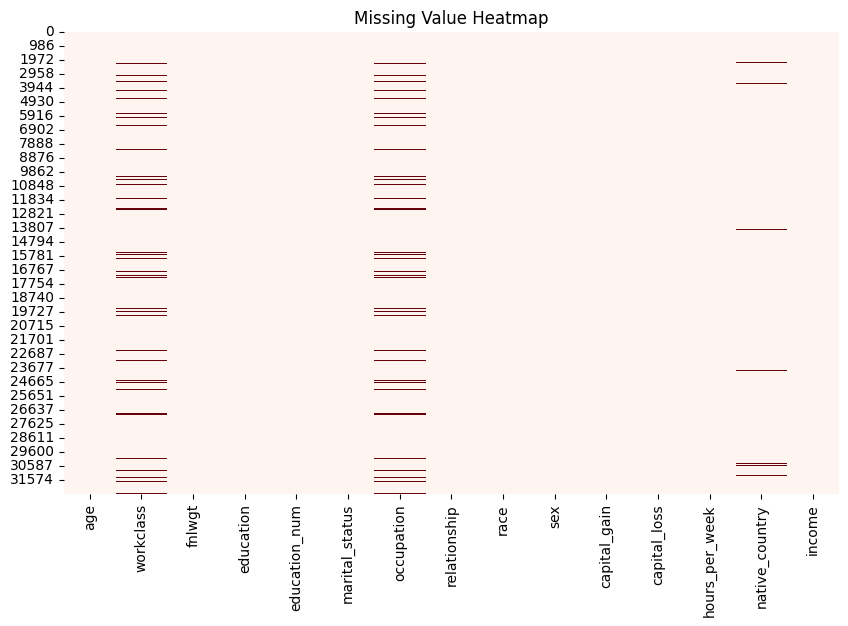

In [336]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df.isna(), cbar=False, cmap="Reds")
plt.title("Missing Value Heatmap")
plt.show()


All the missing values are in categorical columns. We can either drop these rows or impute them. 

In [337]:
#Impute missing values

cat_cols_for_impute = ['workclass','occupation','native_country']
for c in cat_cols_for_impute:
    if c in df.columns:
        df[c] = df[c].fillna('Unknown')

# (If any numeric nulls exist, fill with median)
num_cols = ['age','education_num','capital_gain','capital_loss','hours_per_week','fnlwgt']
for c in num_cols:
    if c in df.columns and df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

print("\n--- NULLS AFTER IMPUTE ---")
print(df.isna().sum().sort_values(ascending=False))


--- NULLS AFTER IMPUTE ---
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64


### 03. EDA

In [338]:
print(f"Shape of dataset: {df.shape}")
print("\n--- Data types ---")
print(df.dtypes)
print("\n--- Preview ---")
display(df.head())

Shape of dataset: (32537, 15)

--- Data types ---
age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

--- Preview ---


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90,Unknown,77053,HS-grad,9,Widowed,Unknown,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Unknown,186061,Some-college,10,Widowed,Unknown,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_38092/734290532.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='income', data=df, palette='Set2')


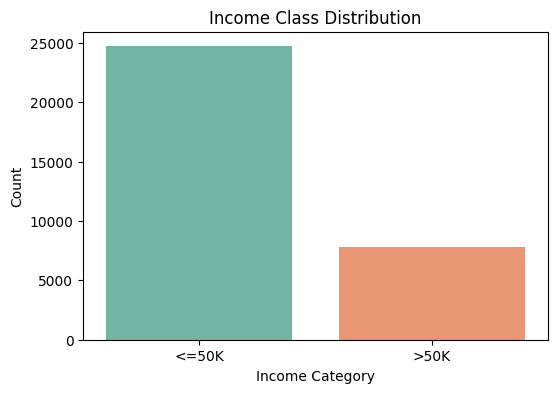

In [339]:
# --- Target variable distribution ---
plt.figure(figsize=(6,4))
sns.countplot(x='income', data=df, palette='Set2')
plt.title("Income Class Distribution")
plt.xlabel("Income Category")
plt.ylabel("Count")
plt.show()


In [340]:
print("\n--- Summary statistics for numeric features ---")
display(df.describe())


--- Summary statistics for numeric features ---


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32537.000000,3.253700e+04,32537.000000,32537.000000,32537.000000,32537.000000
mean,38.585549,1.897808e+05,10.081815,1078.443741,87.368227,40.440329
std,13.637984,1.055565e+05,2.571633,7387.957424,403.101833,12.346889
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.369930e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


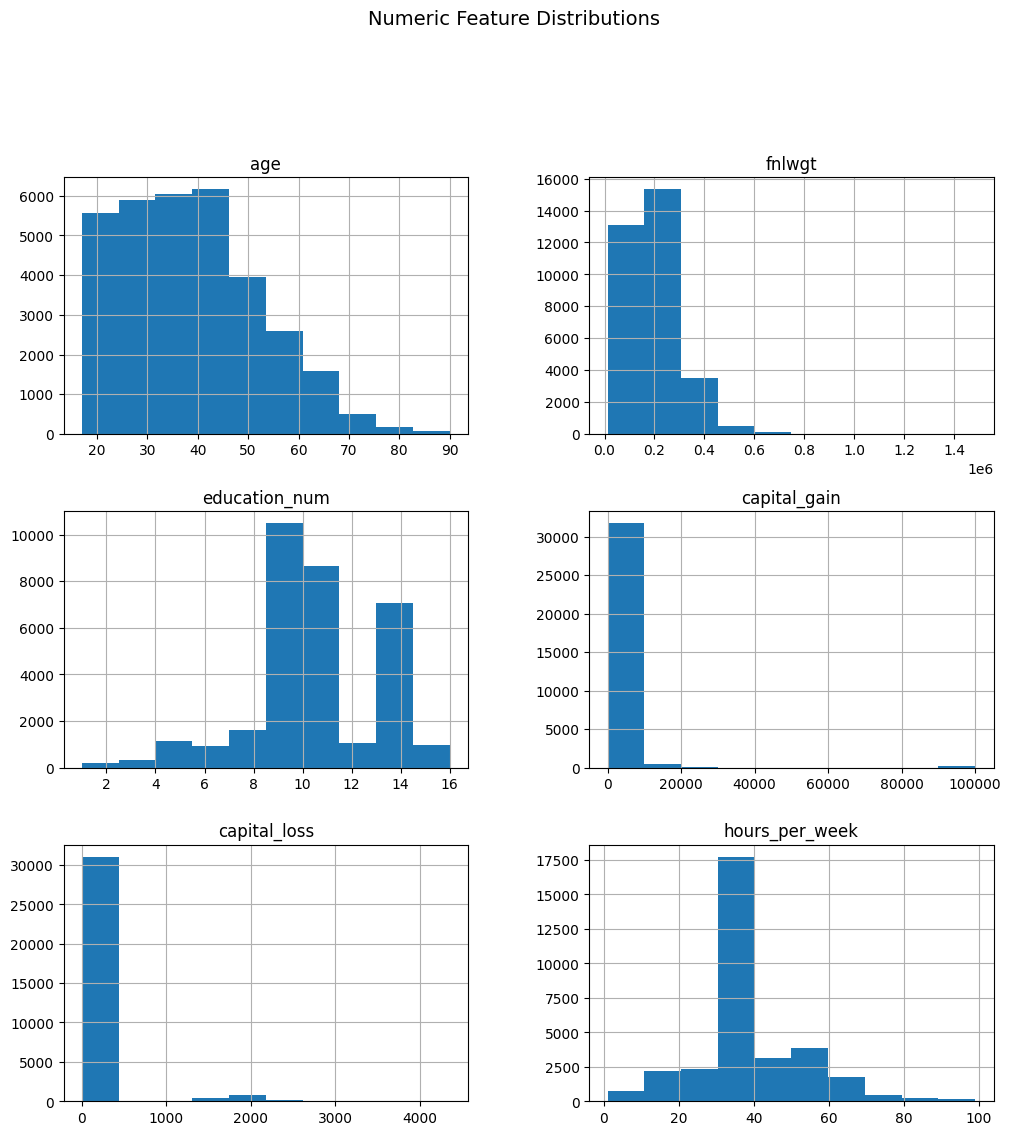

In [341]:
df.hist(figsize=(12,12))
plt.suptitle("Numeric Feature Distributions", y=1.02, fontsize=14)
plt.show()


/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_38092/827241770.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=c, data=df, order=order, palette='cool')


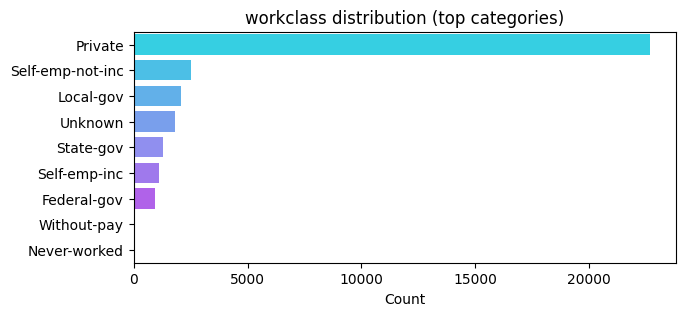

/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_38092/827241770.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=c, data=df, order=order, palette='cool')


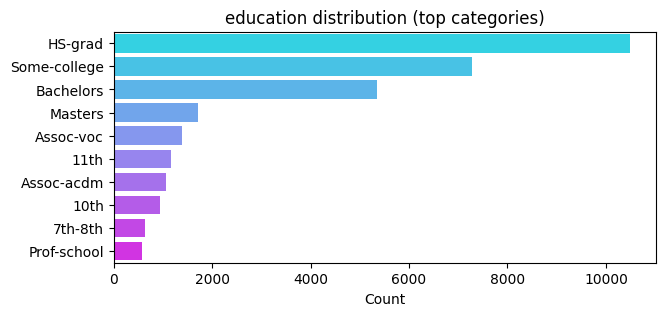

/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_38092/827241770.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=c, data=df, order=order, palette='cool')


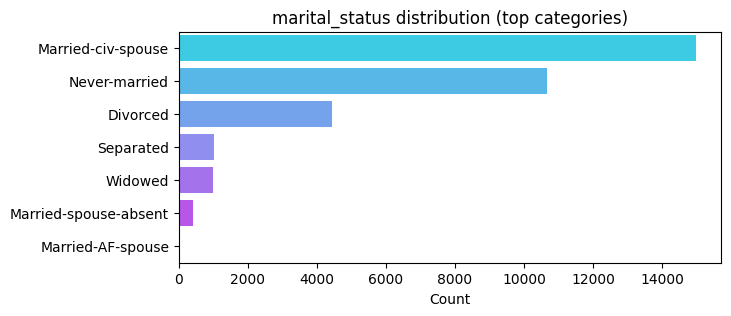

/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_38092/827241770.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=c, data=df, order=order, palette='cool')


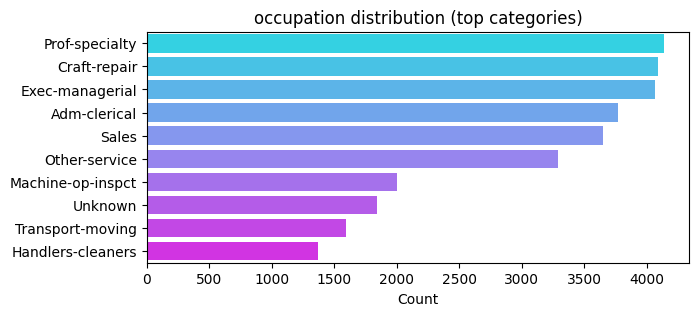

/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_38092/827241770.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=c, data=df, order=order, palette='cool')


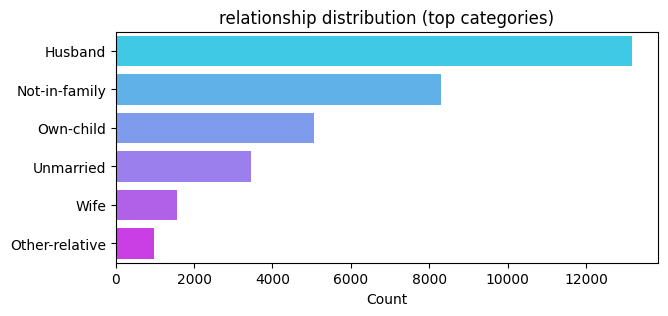

/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_38092/827241770.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=c, data=df, order=order, palette='cool')


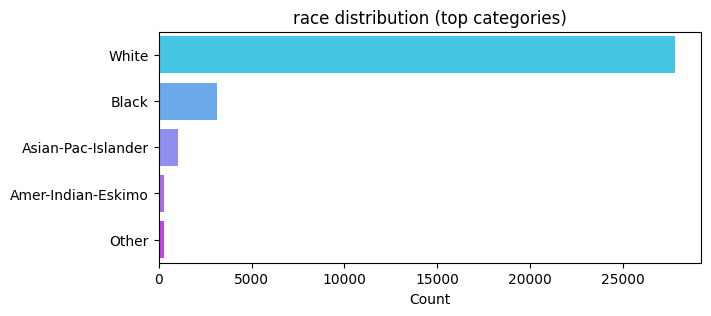

/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_38092/827241770.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=c, data=df, order=order, palette='cool')


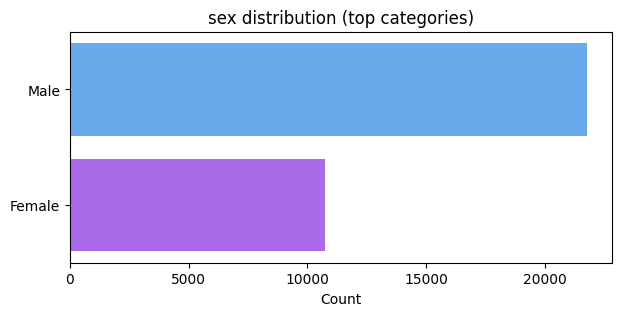

/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_38092/827241770.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=c, data=df, order=order, palette='cool')


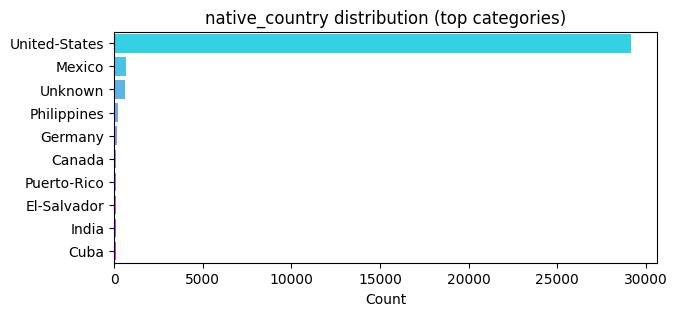

In [342]:
# Categorical features → countplots
categorical_cols = ['workclass','education','marital_status','occupation',
                    'relationship','race','sex','native_country']
for c in categorical_cols:
    plt.figure(figsize=(7,3))
    order = df[c].value_counts().index[:10]
    sns.countplot(y=c, data=df, order=order, palette='cool')
    plt.title(f"{c} distribution (top categories)")
    plt.xlabel("Count")
    plt.ylabel("")
    plt.show()


/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_38092/1732806875.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='income', y=col, data=df, palette='Set2')


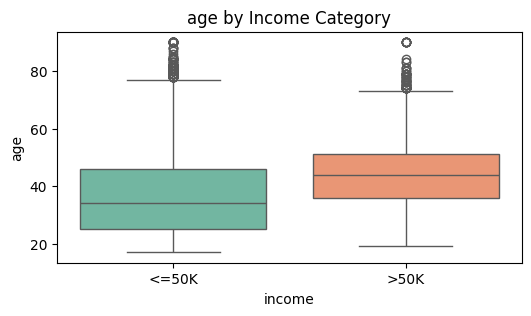

/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_38092/1732806875.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='income', y=col, data=df, palette='Set2')


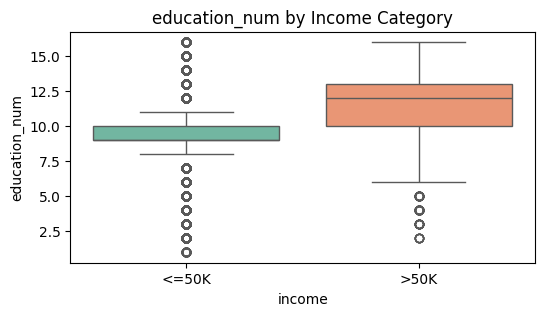

/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_38092/1732806875.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='income', y=col, data=df, palette='Set2')


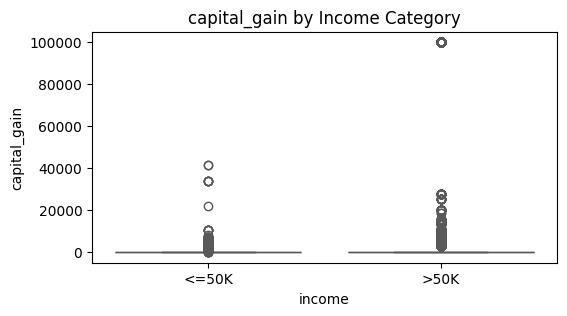

/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_38092/1732806875.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='income', y=col, data=df, palette='Set2')


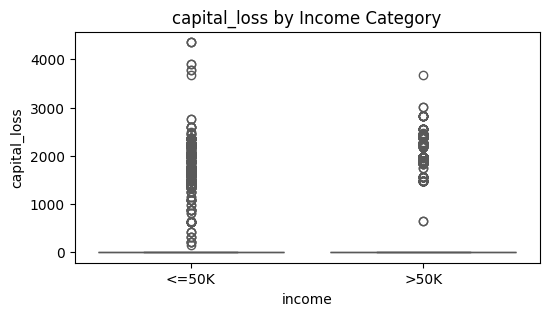

/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_38092/1732806875.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='income', y=col, data=df, palette='Set2')


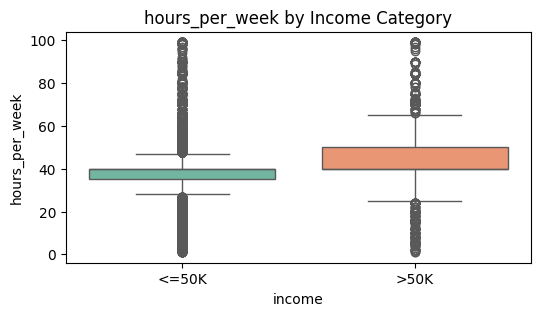

In [343]:
# --- Bivariate analysis (feature vs target: income) ---
# Numeric vs target → boxplots
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='income', y=col, data=df, palette='Set2')
    plt.title(f"{col} by Income Category")
    plt.show()

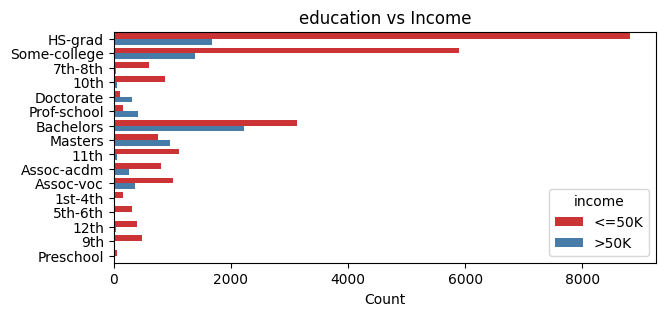

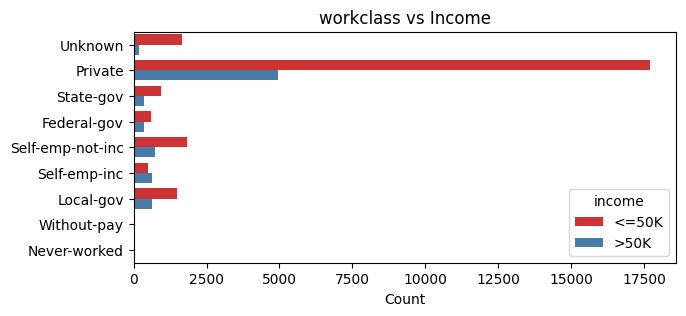

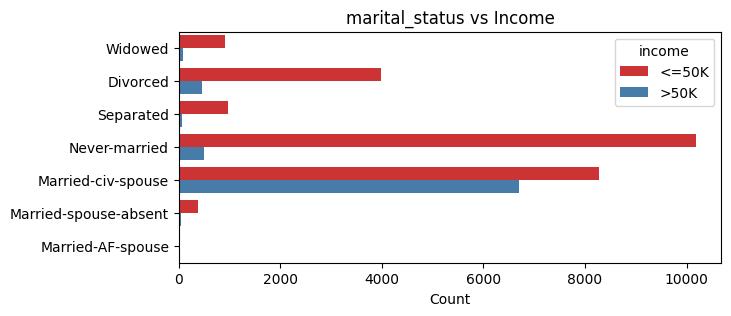

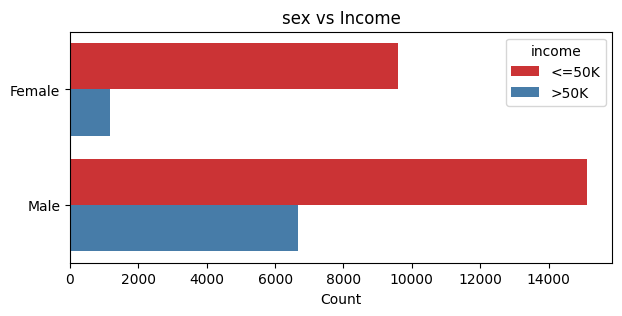

In [344]:
# Categorical vs target → grouped countplots
for c in ['education','workclass','marital_status','sex']:
    plt.figure(figsize=(7,3))
    sns.countplot(y=c, hue='income', data=df, palette='Set1')
    plt.title(f"{c} vs Income")
    plt.xlabel("Count")
    plt.ylabel("")
    plt.show()

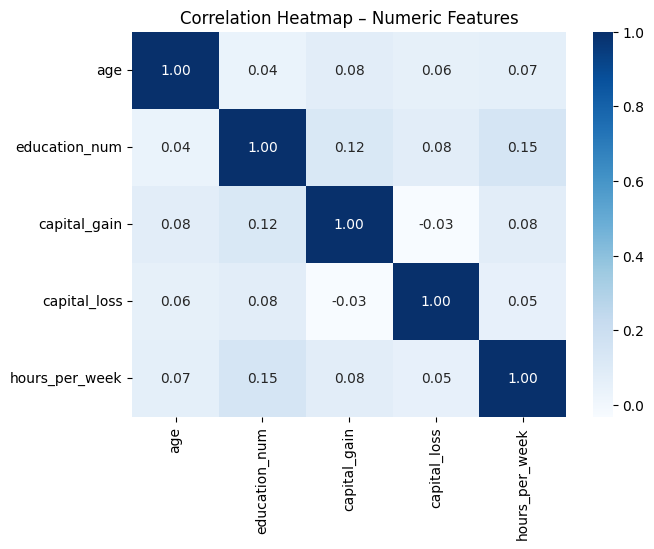

In [345]:
# --- Correlation heatmap (numeric only) ---
plt.figure(figsize=(7,5))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Heatmap – Numeric Features")
plt.show()

Income distribution: The dataset is imbalanced — most individuals earn ≤ 50K.

Age: Right-skewed; majority between 25 and 45 years old.

Work hours: Most participants work ≈ 40 hours per week.

Capital gain/loss: Highly right-skewed; most values are zero.

Workclass: Dominated by Private sector employment.

Education: HS-grad, Some-college, and Bachelors most frequent.

Marital status: Mainly Married-civ-spouse and Never-married.

Occupation: Prof-specialty, Craft-repair, and Exec-managerial common.

Gender: More males than females.

Country: Vast majority from the United States.

Bivariate trends: Higher income linked with older age, longer work hours, higher education, and married status.

Correlations: Education_num, capital_gain, and hours_per_week show mild positive correlations with each other (r ≈ 0.08–0.15).

Age and capital_loss exhibit minimal linear association with other features (r < 0.07).

No multicollinearity is present, confirming all numeric variables provide distinct information.

### 04. Data preprocessing 

In [346]:
def group_workclass(value):
    if value in ['Private']:
        return 'private-sector'
    elif value in ['Self-emp-not-inc', 'Self-emp-inc']:
        return 'self-employed'
    elif value in ['Local-gov', 'State-gov', 'Federal-gov']:
        return 'government'
    else:
        return 'other'

def groupped_marital_stat(value):
    # Married: 1
    # Single: 0
    if value in ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']:
        return 1
    elif value in ['Never-married', 'Divorced', 'Separated', 'Widowed']:
        return 0

def groupped_occupation(occ):
    if occ in ['Prof-specialty', 'Exec-managerial', 'Adm-clerical', 'Tech-support', 'Sales']:
        return 'white_collar'
    elif occ in ['Craft-repair', 'Machine-op-inspct', 'Transport-moving',
                 'Handlers-cleaners', 'Farming-fishing', 'Protective-serv', 'Armed-Forces']:
        return 'blue_collar'
    elif occ in ['Other-service', 'Priv-house-serv']:
        return 'service'
    else:
        return 'other'

def group_relationship(value):
    # Lives with family: 1
    # Doesnt lives with family: 0
    if value in ['Husband', 'Wife', 'Own-child', 'Other-relative']:
        return 1
    elif value in ['Unmarried', 'Not-in-family']:
        return 0

def group_race(value):
    if value in ['Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other']:
        return 'other'
    elif value in ['Black']:
        return 'black'
    elif value in ['White']:
        return 'white'

df['sex'] = df['sex'].apply(lambda val: 1 if val == 'Male' else 0)
df['income'] = df['income'].apply(lambda val: 1 if val == '>50K' else 0)

In [347]:
continent_map = {
    'United-States': 'North America',
    'Mexico': 'North America',
    'Canada': 'North America',
    'Puerto-Rico': 'North America',
    'El-Salvador': 'North America',
    'Cuba': 'North America',
    'Jamaica': 'North America',
    'Dominican-Republic': 'North America',
    'Guatemala': 'North America',
    'Haiti': 'North America',
    'Nicaragua': 'North America',
    'Honduras': 'North America',
    'Trinadad&Tobago': 'North America',
    'Outlying-US(Guam-USVI-etc)': 'Oceania',
    'Columbia': 'South America',
    'Peru': 'South America',
    'Ecuador': 'South America',
    'Germany': 'Europe',
    'England': 'Europe',
    'Italy': 'Europe',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Greece': 'Europe',
    'France': 'Europe',
    'Ireland': 'Europe',
    'Scotland': 'Europe',
    'Yugoslavia': 'Europe',
    'Hungary': 'Europe',
    'Holand-Netherlands': 'Europe',
    'Philippines': 'Asia',
    'India': 'Asia',
    'China': 'Asia',
    'Japan': 'Asia',
    'Vietnam': 'Asia',
    'Taiwan': 'Asia',
    'Iran': 'Asia',
    'Cambodia': 'Asia',
    'Thailand': 'Asia',
    'Laos': 'Asia',
    'Hong': 'Asia',
    'South': 'Other',
    'Unknown':'Other'
}

In [348]:
df["workclass"] = df["workclass"].apply(group_workclass)
df["is_married"] = df["marital_status"].apply(groupped_marital_stat)
df["occupation"] = df["occupation"].apply(groupped_occupation)
df["is_lives_with_family"] = df["relationship"].apply(group_relationship)
df['race'] = df['race'].apply(group_race)
df['continent'] = df['native_country'].map(continent_map)

In [349]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 32537 entries, 0 to 32560
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   32537 non-null  int64 
 1   workclass             32537 non-null  object
 2   fnlwgt                32537 non-null  int64 
 3   education             32537 non-null  object
 4   education_num         32537 non-null  int64 
 5   marital_status        32537 non-null  object
 6   occupation            32537 non-null  object
 7   relationship          32537 non-null  object
 8   race                  32537 non-null  object
 9   sex                   32537 non-null  int64 
 10  capital_gain          32537 non-null  int64 
 11  capital_loss          32537 non-null  int64 
 12  hours_per_week        32537 non-null  int64 
 13  native_country        32537 non-null  object
 14  income                32537 non-null  int64 
 15  is_married            32537 non-null  int

(32537, 18)

In [350]:
df = df[~(df["workclass"].isin(['other']))]
df = df[~(df["occupation"].isin(['other']))]
df = df[~(df["continent"].isin(['Other', 'Oceania']))]

In [351]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 30040 entries, 1 to 32560
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   30040 non-null  int64 
 1   workclass             30040 non-null  object
 2   fnlwgt                30040 non-null  int64 
 3   education             30040 non-null  object
 4   education_num         30040 non-null  int64 
 5   marital_status        30040 non-null  object
 6   occupation            30040 non-null  object
 7   relationship          30040 non-null  object
 8   race                  30040 non-null  object
 9   sex                   30040 non-null  int64 
 10  capital_gain          30040 non-null  int64 
 11  capital_loss          30040 non-null  int64 
 12  hours_per_week        30040 non-null  int64 
 13  native_country        30040 non-null  object
 14  income                30040 non-null  int64 
 15  is_married            30040 non-null  int

(30040, 18)

In [352]:
#df = df[(16 <= df["hours_per_week"]) & (df["hours_per_week"] <= 60)]


In [353]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 30040 entries, 1 to 32560
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   30040 non-null  int64 
 1   workclass             30040 non-null  object
 2   fnlwgt                30040 non-null  int64 
 3   education             30040 non-null  object
 4   education_num         30040 non-null  int64 
 5   marital_status        30040 non-null  object
 6   occupation            30040 non-null  object
 7   relationship          30040 non-null  object
 8   race                  30040 non-null  object
 9   sex                   30040 non-null  int64 
 10  capital_gain          30040 non-null  int64 
 11  capital_loss          30040 non-null  int64 
 12  hours_per_week        30040 non-null  int64 
 13  native_country        30040 non-null  object
 14  income                30040 non-null  int64 
 15  is_married            30040 non-null  int

(30040, 18)

#### Handle Outliers
Outliers in the variables named capital_gain and capital_loss in the data set were detected and removed from the data set.

In [354]:
def remove_outliers_iqr_nonzero(df, column):
    
    non_zero = df[df[column] != 0]
        
    q1 = non_zero[column].quantile(0.25)
    q3 = non_zero[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    non_outliers = non_zero[(non_zero[column] >= lower_bound) & (non_zero[column] <= upper_bound)]
    
    zeros = df[df[column] == 0]

    cleaned_df = pd.concat([zeros, non_outliers], axis=0).sort_index()

    return cleaned_df


In [355]:
df = remove_outliers_iqr_nonzero(df=df, column='capital_gain')
df = remove_outliers_iqr_nonzero(df=df, column='capital_loss')

In [356]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 29791 entries, 62 to 32560
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   29791 non-null  int64 
 1   workclass             29791 non-null  object
 2   fnlwgt                29791 non-null  int64 
 3   education             29791 non-null  object
 4   education_num         29791 non-null  int64 
 5   marital_status        29791 non-null  object
 6   occupation            29791 non-null  object
 7   relationship          29791 non-null  object
 8   race                  29791 non-null  object
 9   sex                   29791 non-null  int64 
 10  capital_gain          29791 non-null  int64 
 11  capital_loss          29791 non-null  int64 
 12  hours_per_week        29791 non-null  int64 
 13  native_country        29791 non-null  object
 14  income                29791 non-null  int64 
 15  is_married            29791 non-null  in

(29791, 18)

### 05. Feature Enginnering 

In [ ]:
df['capital_diff'] = df['capital_gain'] - df['capital_loss']
df['has_capital_gain'] = (df['capital_gain'] > 0).astype(int)
df['has_capital_loss'] = (df['capital_loss'] > 0).astype(int)
df['has_no_capital_activity'] = ((df['capital_gain'] == 0) & (df['capital_loss'] == 0)).astype(int)


In [358]:
# Binning
df['age_group'] = pd.cut(df['age'], bins=[16,25,35,45,60,100],
                         labels=['young','early-career','mid','senior','retired'])
df['work_hours_category'] = pd.cut(df['hours_per_week'], bins=[0,35,40,60,100],
                                   labels=['part-time','full-time','overtime','extreme'])


In [359]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 29791 entries, 62 to 32560
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      29791 non-null  int64   
 1   workclass                29791 non-null  object  
 2   fnlwgt                   29791 non-null  int64   
 3   education                29791 non-null  object  
 4   education_num            29791 non-null  int64   
 5   marital_status           29791 non-null  object  
 6   occupation               29791 non-null  object  
 7   relationship             29791 non-null  object  
 8   race                     29791 non-null  object  
 9   sex                      29791 non-null  int64   
 10  capital_gain             29791 non-null  int64   
 11  capital_loss             29791 non-null  int64   
 12  hours_per_week           29791 non-null  int64   
 13  native_country           29791 non-null  object  
 14  income    

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,...,income,is_married,is_lives_with_family,continent,capital_diff,has_capital_gain,has_capital_loss,has_no_capital_activity,age_group,work_hours_category
62,44,private-sector,162028,Some-college,10,Married-civ-spouse,white_collar,Wife,white,0,...,1,1,1,North America,-2415,0,1,0,mid,part-time
63,51,self-employed,160724,Bachelors,13,Married-civ-spouse,white_collar,Husband,other,1,...,1,1,1,Asia,-2415,0,1,0,senior,full-time
64,41,private-sector,132222,Prof-school,15,Married-civ-spouse,white_collar,Husband,white,1,...,1,1,1,North America,-2415,0,1,0,mid,full-time
66,37,private-sector,329980,Masters,14,Married-civ-spouse,white_collar,Husband,white,1,...,1,1,1,North America,-2415,0,1,0,mid,overtime
67,55,self-employed,124137,Prof-school,15,Married-civ-spouse,white_collar,Husband,white,1,...,1,1,1,Europe,-2415,0,1,0,senior,part-time


### 06. Drop redundant / non-informative features

* Fnlwgt - Survey sampling weight does not describe personal attribute and not linked to income
* Relationship - Relationship feature is overlapping with marital_status
* Education - Education and education_num represent the same information. 
* capital_gain, capital_loss: We have performed the desired Label Encoding process for these variables. Since the number of zeros in both columns is quite high and the values ​​in the columns are too high, these columns have been removed.

* native_country: The number of classes in this variable is quite high compared to other variables and for this reason, the classes in the variable have been grouped into the continent variable. In order to reduce the noise in the dataset, these variables have been removed from the dataset.


In [360]:
df = df.drop(['fnlwgt','education','capital_gain', 'capital_loss','native_country', 'relationship', 'marital_status','age','hours_per_week'], axis=1)


In [361]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 29791 entries, 62 to 32560
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   workclass                29791 non-null  object  
 1   education_num            29791 non-null  int64   
 2   occupation               29791 non-null  object  
 3   race                     29791 non-null  object  
 4   sex                      29791 non-null  int64   
 5   income                   29791 non-null  int64   
 6   is_married               29791 non-null  int64   
 7   is_lives_with_family     29791 non-null  int64   
 8   continent                29791 non-null  object  
 9   capital_diff             29791 non-null  int64   
 10  has_capital_gain         29791 non-null  int64   
 11  has_capital_loss         29791 non-null  int64   
 12  has_no_capital_activity  29791 non-null  int64   
 13  age_group                29791 non-null  category
 14  work_hours

(29791, 15)

### 07. One hot encoding

In [362]:
categorical_columns = ['workclass', 'occupation', 'race', 'continent','age_group', 'work_hours_category']
df = pd.get_dummies(df, columns=categorical_columns)

In [363]:
df.shape
df.head().T

,62,63,64,66,67
education_num,10,13,15,14,15
sex,0,1,1,1,1
income,1,1,1,1,1
is_married,1,1,1,1,1
is_lives_with_family,1,1,1,1,1
capital_diff,-2415,-2415,-2415,-2415,-2415
has_capital_gain,0,0,0,0,0
has_capital_loss,1,1,1,1,1
has_no_capital_activity,0,0,0,0,0
workclass_government,False,False,False,False,False


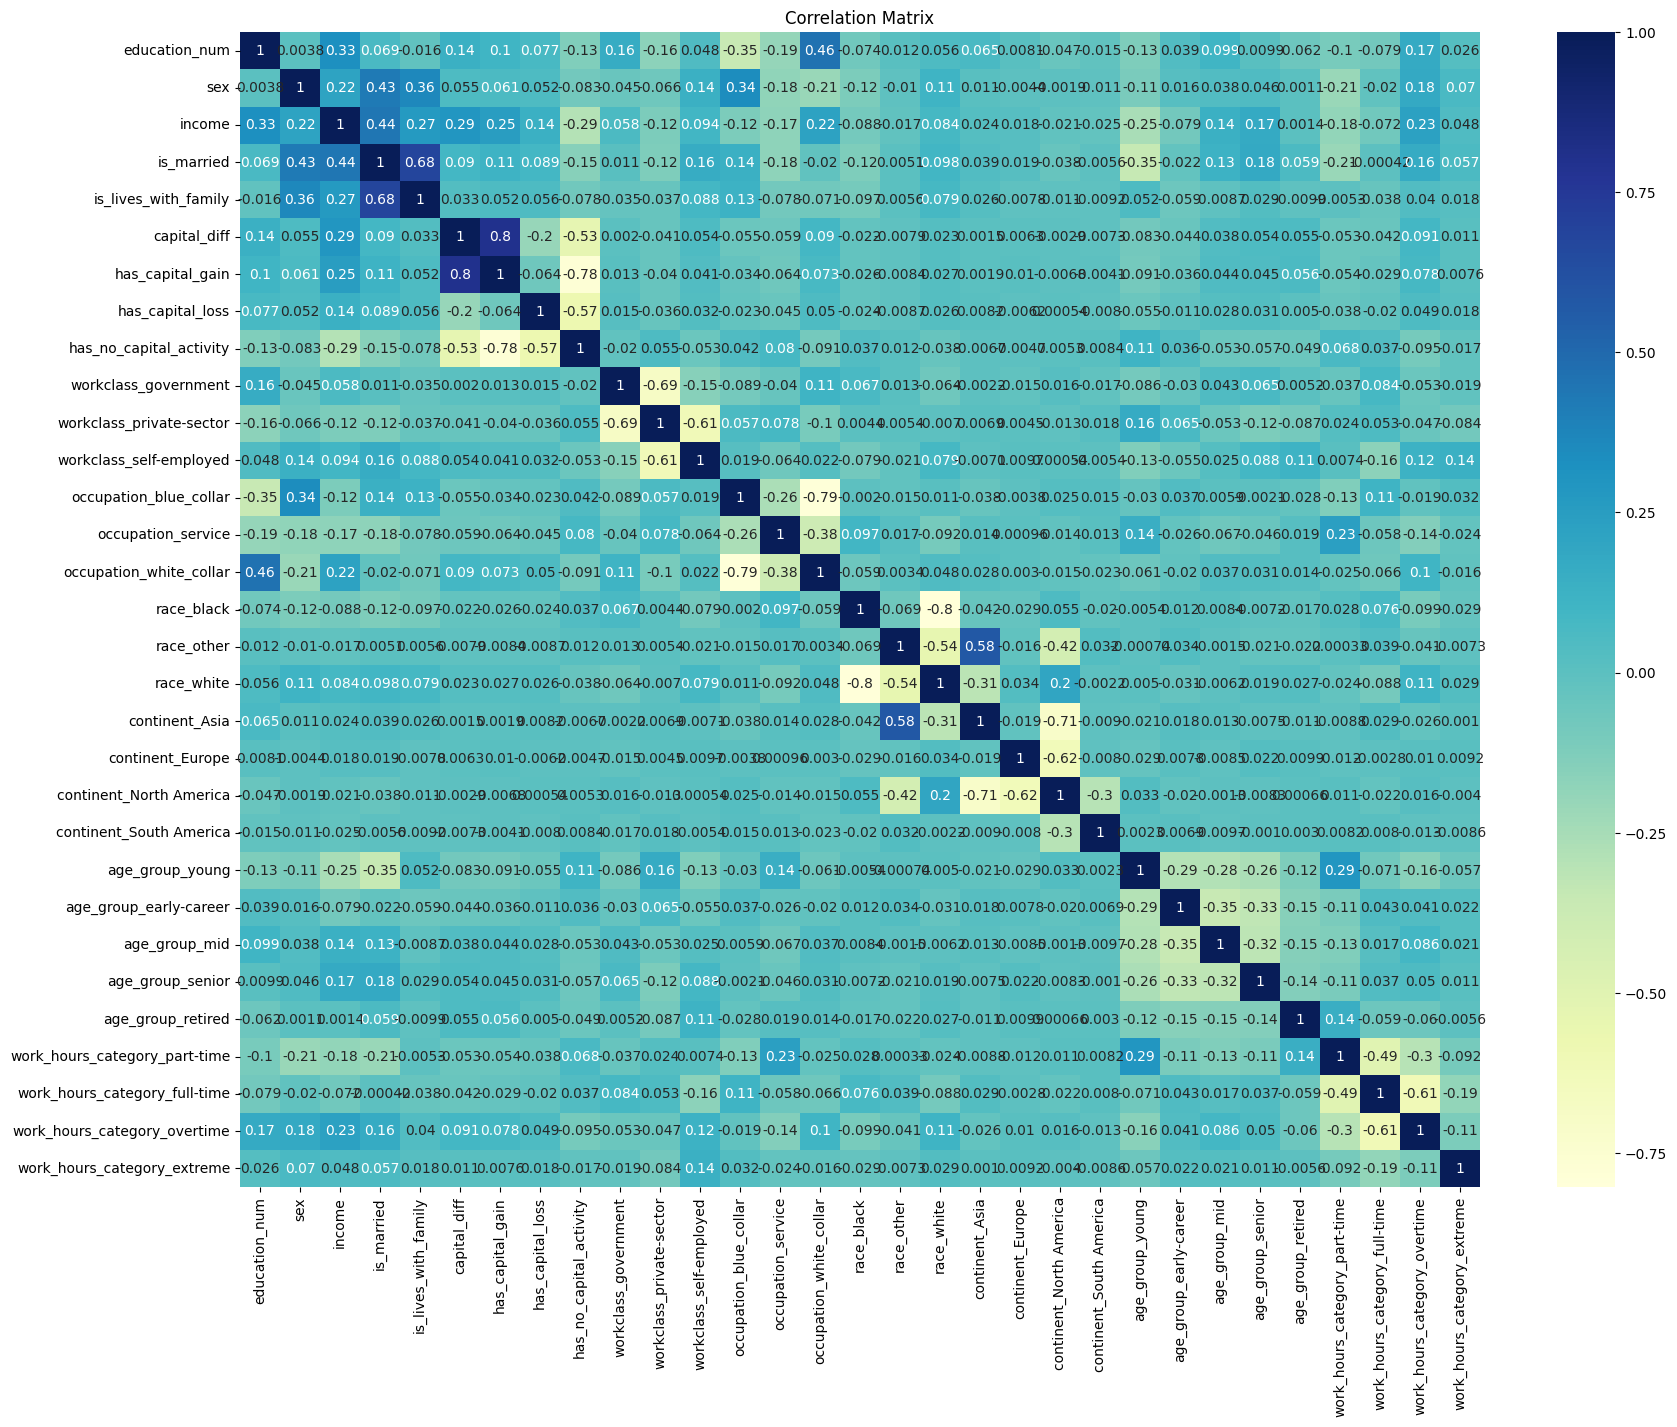

In [364]:
co_mtx=df.corr(numeric_only=True)
plt.figure(figsize=(20,15))
sns.heatmap(co_mtx, cmap="YlGnBu", annot=True)
plt.title("Correlation Matrix")
plt.show()

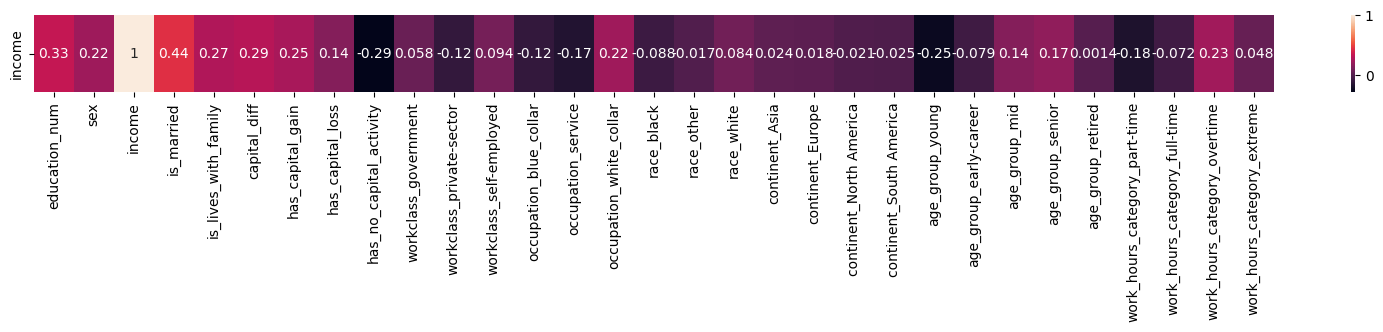

In [365]:
plt.figure(figsize=(20,1))
sns.heatmap(co_mtx[['income']].T, annot=True)
plt.show()

## Model Development

In [366]:
X = df.drop('income', axis=1)
y = df['income']

In [367]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

* linear model (e.g., Logistic Regression, Linear Regression)
* tree-based model (e.g., Decision Tree, Random Forest)
* boosting model (e.g., XGBoost, LightGBM, CatBoost)
* advanced model (e.g., Neural Network, AutoML pipeline)*

In [ ]:
# 1) LINEAR: Logistic Regression (with scaling)
log_reg = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False) if getattr(X_train, "shape", None) and not hasattr(X_train, "toarray") else StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs'))
])

log_reg = eval_model("Logistic Regression", log_reg, X_train, y_train, X_test, y_test)


In [ ]:
# 2) TREE-BASED: Decision Tree, and Random Forest

dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced_subsample'
)

In [ ]:
# 3) BOOSTING: Gradient Boosting (pure sklearn; no extra deps)
gb_model = GradientBoostingClassifier(random_state=42)

In [ ]:
mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",                 # default
        learning_rate="adaptive",      # reduce lr when plateau
        learning_rate_init=1e-3,       # try 1e-3 → 5e-4 → 1e-4
        alpha=1e-3,                    # L2 reg (try 1e-4 to 1e-2)
        batch_size=256,                # mini-batch; adjust to data size
        max_iter=600,                  # allow more steps
        early_stopping=True,           # stop when val score plateaus
        validation_fraction=0.15,
        n_iter_no_change=20,
        random_state=42,
        verbose=False
    ))
])
mlp.fit(X_train, y_train)

## Evaluation & Comparison

In [378]:
def eval_model(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)
    # some models may not have predict_proba; fall back to decision_function if present
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(Xte)[:, 1]
    elif hasattr(model, "decision_function"):
        import numpy as np
        df = model.decision_function(Xte)
        # map to [0,1] via rank for a fair AUC (monotonic transform)
        rk = (df - df.min()) / (df.max() - df.min() + 1e-12)
        y_prob = rk
    else:
        # last resort: use predictions as 'probability'
        y_prob = y_pred

    acc = accuracy_score(yte, y_pred)
    auc = roc_auc_score(yte, y_prob)
    f1  = f1_score(yte, y_pred)
    print(f"{name} → Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f} | F1: {f1:.3f}")
    return model

In [379]:
log_reg = eval_model("Logistic Regression", log_reg, X_train, y_train, X_test, y_test)
dt_model = eval_model("Decision Tree", dt_model, X_train, y_train, X_test, y_test)
rf_model = eval_model("Random Forest", rf_model, X_train, y_train, X_test, y_test)
gb_model = eval_model("Gradient Boosting", gb_model, X_train, y_train, X_test, y_test)
mlp = eval_model("Neural Network (MLP)", mlp, X_train, y_train, X_test, y_test)

Logistic Regression → Accuracy: 0.800 | ROC-AUC: 0.903 | F1: 0.678
Decision Tree → Accuracy: 0.795 | ROC-AUC: 0.860 | F1: 0.664
Random Forest → Accuracy: 0.814 | ROC-AUC: 0.891 | F1: 0.677
Gradient Boosting → Accuracy: 0.863 | ROC-AUC: 0.915 | F1: 0.687
Neural Network (MLP) → Accuracy: 0.844 | ROC-AUC: 0.907 | F1: 0.668


In [390]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, RocCurveDisplay,
    precision_recall_curve, PrecisionRecallDisplay,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# ---------- Core evaluator for CLASSIFICATION ----------
def eval_model(name, model, Xtr, ytr, Xte, yte, plot=True, tune_threshold=True):
    """Train, evaluate, (optionally) plot & threshold-tune a classifier. Returns metrics dict."""
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)

    # Probabilities/scores for curves
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(Xte)[:, 1]
    elif hasattr(model, "decision_function"):
        s = model.decision_function(Xte)
        # normalize scores to [0,1] for AUC/PR display
        y_score = (s - s.min()) / (s.max() - s.min() + 1e-12)
    else:
        y_score = y_pred.astype(float)

    # Base metrics at default threshold 0.5
    acc = accuracy_score(yte, y_pred)
    prec = precision_score(yte, y_pred, zero_division=0)
    rec = recall_score(yte, y_pred, zero_division=0)
    f1 = f1_score(yte, y_pred, zero_division=0)
    auc = roc_auc_score(yte, y_score)

    # --- Error analysis (simple & useful) ---
    cm = confusion_matrix(yte, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    majority_miscls = "Positive(>50K)" if fn > fp else "Negative(<=50K)"
    print(f"\n{name} — Error analysis:")
    print(f"Confusion Matrix :\n[TN FP]{cm[0]}\n[FN TP]{cm[1]}\n")
    print(f"Most misclassified class: {majority_miscls}")
    mis_idx = np.where(y_pred != yte)[0][:10]
    print(f"Example misclassified indices (first 10): {mis_idx.tolist()}")
    print("\nClassification report:\n", classification_report(yte, y_pred, digits=3, zero_division=0))

    # --- Plots ---
    if plot:
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K','>50K']).plot(values_format='d')
        plt.title(f"{name} — Confusion Matrix"); plt.show()

        fpr, tpr, _ = roc_curve(yte, y_score)
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, name=name).plot()
        plt.title(f"{name} — ROC Curve"); plt.show()

        pr, rc, _ = precision_recall_curve(yte, y_score)
        PrecisionRecallDisplay(precision=pr, recall=rc).plot()
        plt.title(f"{name} — Precision–Recall Curve"); plt.show()

    best = {"threshold": 0.5, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}

    # --- Threshold tuning (maximize F1) ---
    if tune_threshold and (np.unique(y_score).size > 2):
        pr, rc, thr = precision_recall_curve(yte, y_score)
        f1s = (2*pr*rc)/(pr+rc+1e-12)
        # exclude last PR point (no threshold)
        i = np.nanargmax(f1s[:-1])
        best_t = thr[i]
        y_hat_best = (y_score >= best_t).astype(int)

        best = {
            "threshold": float(best_t),
            "accuracy": accuracy_score(yte, y_hat_best),
            "precision": precision_score(yte, y_hat_best, zero_division=0),
            "recall": recall_score(yte, y_hat_best, zero_division=0),
            "f1": f1_score(yte, y_hat_best, zero_division=0),
            "roc_auc": auc  # AUC unaffected by threshold
        }
        print(f"{name} — Best F1 threshold: {best_t:.3f} → "
              f"Acc={best['accuracy']:.3f} | Prec={best['precision']:.3f} | "
              f"Rec={best['recall']:.3f} | F1={best['f1']:.3f} | AUC={best['roc_auc']:.3f}")

    # Pack metrics for results table
    metrics = {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": auc,
        "BestThr": best["threshold"],
        "Best_Accuracy": best["accuracy"],
        "Best_Precision": best["precision"],
        "Best_Recall": best["recall"],
        "Best_F1": best["f1"]
    }
    return metrics





Logistic Regression — Error analysis:
Confusion Matrix :
[TN FP][3520  978]
[FN TP][ 211 1250]

Most misclassified class: Negative(<=50K)
Example misclassified indices (first 10): [2, 4, 5, 7, 9, 10, 13, 14, 17, 29]

Classification report:
               precision    recall  f1-score   support

           0      0.943     0.783     0.856      4498
           1      0.561     0.856     0.678      1461

    accuracy                          0.800      5959
   macro avg      0.752     0.819     0.767      5959
weighted avg      0.850     0.800     0.812      5959



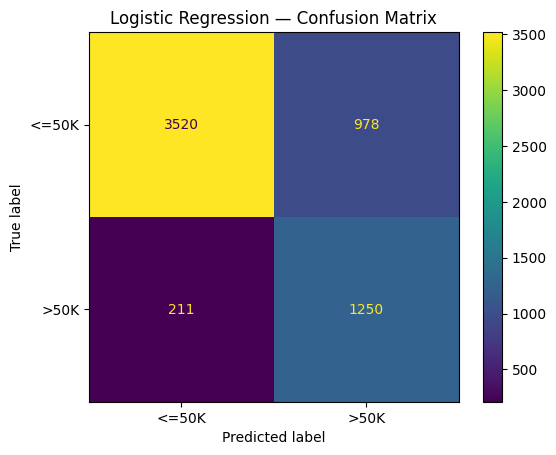

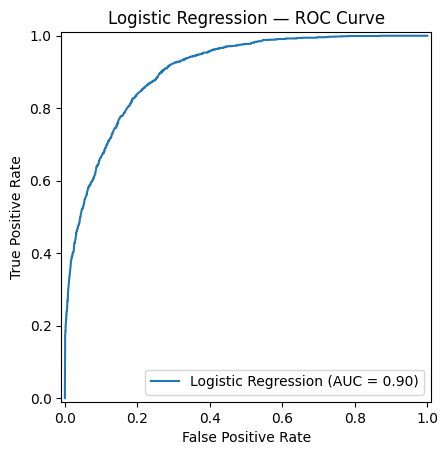

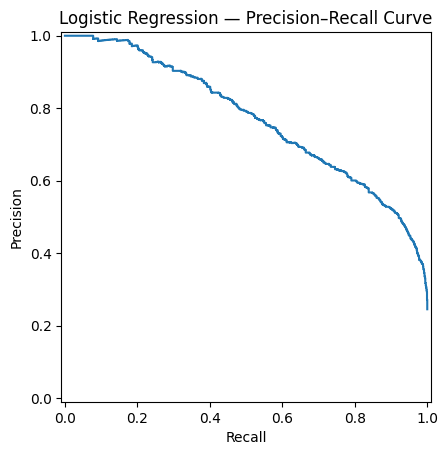

Logistic Regression — Best F1 threshold: 0.597 → Acc=0.830 | Prec=0.623 | Rec=0.777 | F1=0.691 | AUC=0.903

Decision Tree — Error analysis:
Confusion Matrix :
[TN FP][3531  967]
[FN TP][ 254 1207]

Most misclassified class: Negative(<=50K)
Example misclassified indices (first 10): [0, 5, 7, 10, 12, 13, 14, 17, 18, 21]

Classification report:
               precision    recall  f1-score   support

           0      0.933     0.785     0.853      4498
           1      0.555     0.826     0.664      1461

    accuracy                          0.795      5959
   macro avg      0.744     0.806     0.758      5959
weighted avg      0.840     0.795     0.806      5959



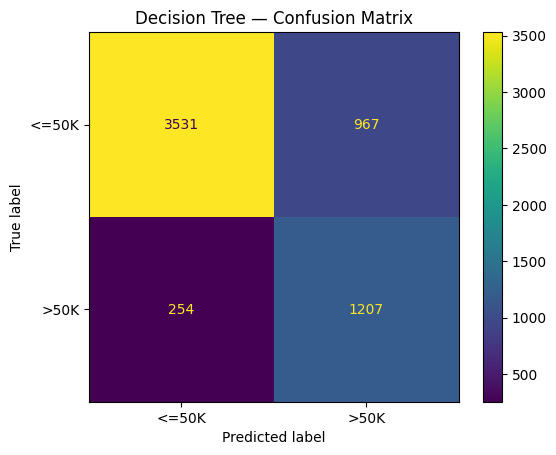

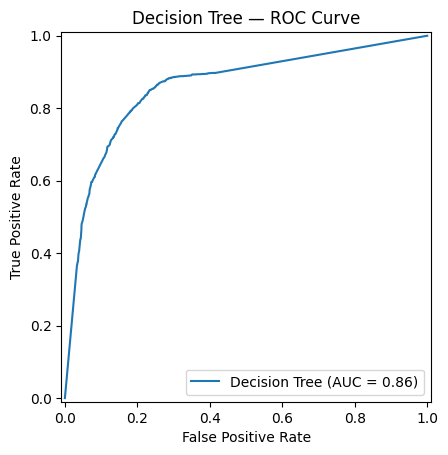

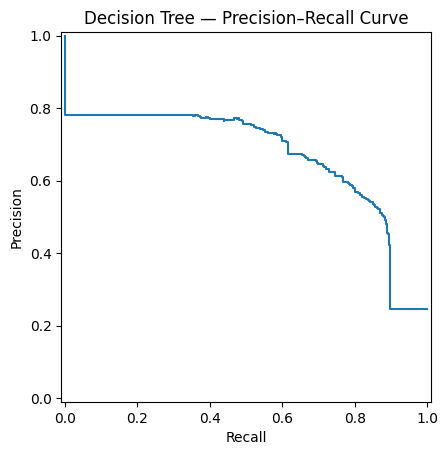

Decision Tree — Best F1 threshold: 0.634 → Acc=0.824 | Prec=0.613 | Rec=0.763 | F1=0.680 | AUC=0.860

Random Forest — Error analysis:
Confusion Matrix :
[TN FP][3687  811]
[FN TP][ 299 1162]

Most misclassified class: Negative(<=50K)
Example misclassified indices (first 10): [4, 5, 7, 10, 12, 13, 14, 17, 21, 29]

Classification report:
               precision    recall  f1-score   support

           0      0.925     0.820     0.869      4498
           1      0.589     0.795     0.677      1461

    accuracy                          0.814      5959
   macro avg      0.757     0.808     0.773      5959
weighted avg      0.843     0.814     0.822      5959



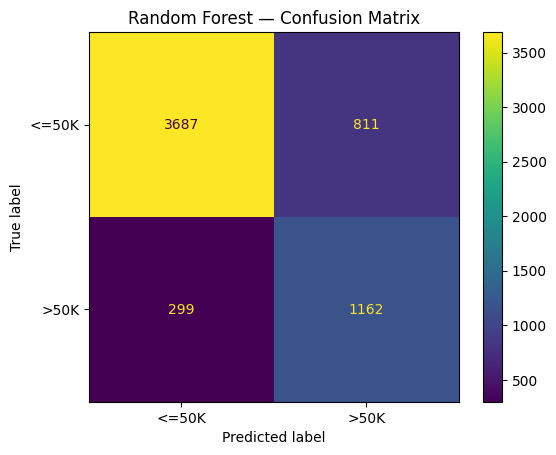

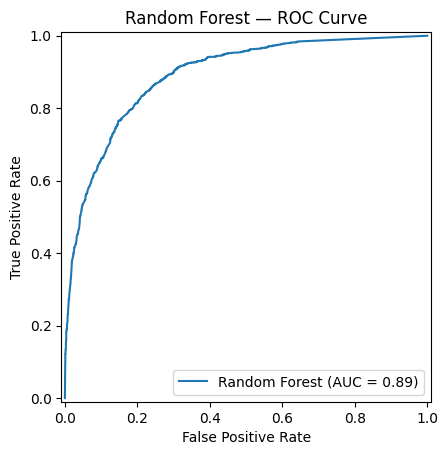

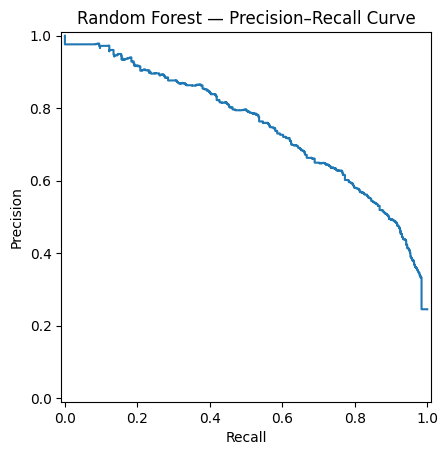

Random Forest — Best F1 threshold: 0.552 → Acc=0.831 | Prec=0.628 | Rec=0.764 | F1=0.689 | AUC=0.891

Gradient Boosting — Error analysis:
Confusion Matrix :
[TN FP][4246  252]
[FN TP][564 897]

Most misclassified class: Positive(>50K)
Example misclassified indices (first 10): [4, 5, 7, 10, 17, 21, 25, 35, 40, 41]

Classification report:
               precision    recall  f1-score   support

           0      0.883     0.944     0.912      4498
           1      0.781     0.614     0.687      1461

    accuracy                          0.863      5959
   macro avg      0.832     0.779     0.800      5959
weighted avg      0.858     0.863     0.857      5959



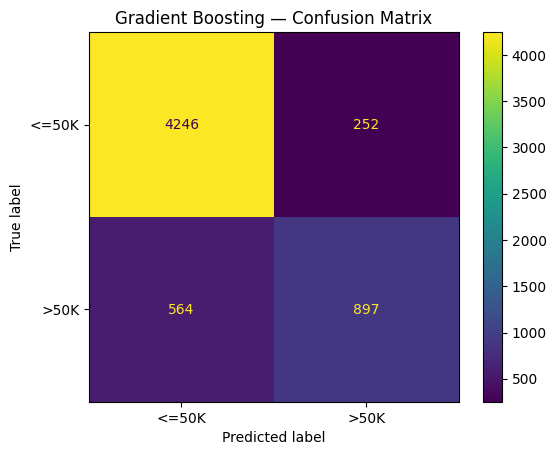

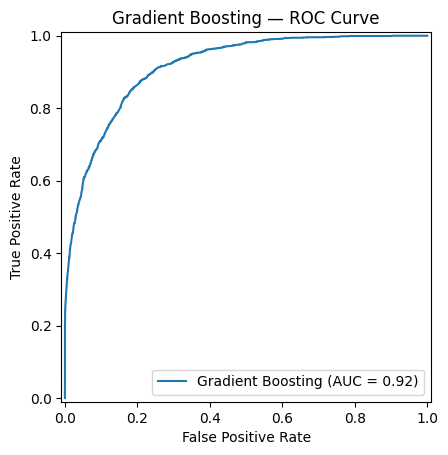

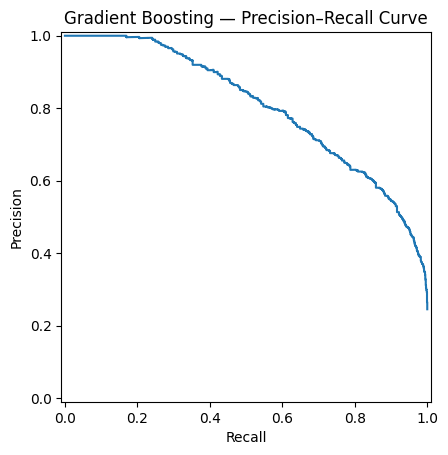

Gradient Boosting — Best F1 threshold: 0.291 → Acc=0.835 | Prec=0.623 | Rec=0.828 | F1=0.711 | AUC=0.915

Neural Network (MLP) — Error analysis:
Confusion Matrix :
[TN FP][4098  400]
[FN TP][528 933]

Most misclassified class: Positive(>50K)
Example misclassified indices (first 10): [4, 5, 7, 10, 17, 21, 31, 34, 35, 40]

Classification report:
               precision    recall  f1-score   support

           0      0.886     0.911     0.898      4498
           1      0.700     0.639     0.668      1461

    accuracy                          0.844      5959
   macro avg      0.793     0.775     0.783      5959
weighted avg      0.840     0.844     0.842      5959



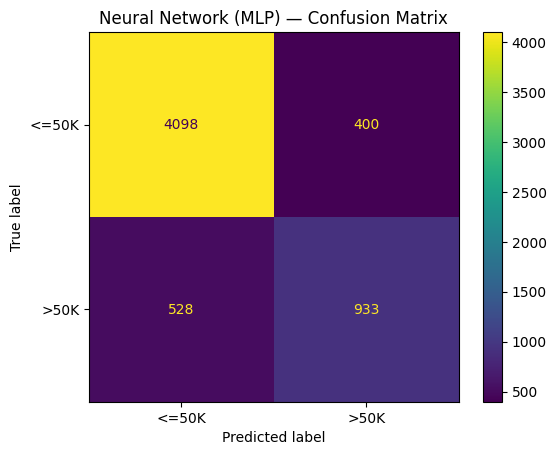

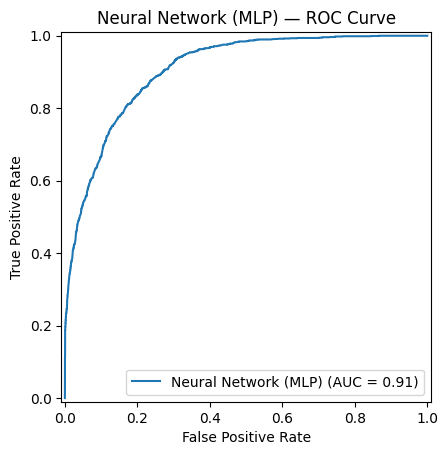

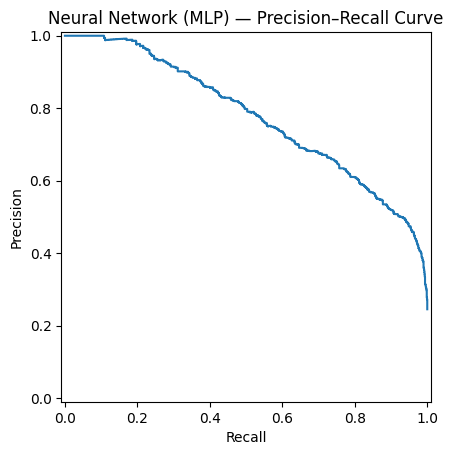

Neural Network (MLP) — Best F1 threshold: 0.408 → Acc=0.841 | Prec=0.653 | Rec=0.751 | F1=0.699 | AUC=0.907

=== Results (default 0.5 threshold & best-F1 threshold) ===
               Model  Accuracy  Precision   Recall       F1  ROC_AUC  BestThr  Best_Accuracy  Best_Precision  Best_Recall  Best_F1
   Gradient Boosting  0.863064   0.780679 0.613963 0.687356 0.915315 0.290699       0.834872        0.622748     0.828200 0.710928
Neural Network (MLP)  0.844269   0.699925 0.638604 0.667860 0.906774 0.407548       0.841081        0.652976     0.750856 0.698504
 Logistic Regression  0.800470   0.561041 0.855578 0.677690 0.903063 0.596669       0.829837        0.622600     0.776865 0.691230
       Random Forest  0.813727   0.588951 0.795346 0.676762 0.890598 0.552015       0.831180        0.628025     0.763860 0.689314
       Decision Tree  0.795100   0.555198 0.826146 0.664099 0.860018 0.633991       0.823964        0.613311     0.763176 0.680085

Best per-metric (by Best_* columns):
Best_Ac

In [391]:
# ---------- Run your models (examples; assume they are defined) ----------
summary = []
summary.append(eval_model("Logistic Regression", log_reg, X_train, y_train, X_test, y_test))
summary.append(eval_model("Decision Tree", dt_model, X_train, y_train, X_test, y_test))
summary.append(eval_model("Random Forest", rf_model, X_train, y_train, X_test, y_test))
summary.append(eval_model("Gradient Boosting", gb_model, X_train, y_train, X_test, y_test))
summary.append(eval_model("Neural Network (MLP)", mlp, X_train, y_train, X_test, y_test))

# ---------- Results table & best-per-metric ----------
res = pd.DataFrame(summary)
print("\n=== Results (default 0.5 threshold & best-F1 threshold) ===")
print(res[["Model","Accuracy","Precision","Recall","F1","ROC_AUC","BestThr","Best_Accuracy","Best_Precision","Best_Recall","Best_F1"]]
      .sort_values("Best_F1", ascending=False).to_string(index=False))

print("\nBest per-metric (by Best_* columns):")
for m in ["Best_Accuracy","Best_Precision","Best_Recall","Best_F1"]:
    best_row = res.loc[res[m].idxmax()]
    print(f"{m}: {best_row['Model']} = {best_row[m]:.3f} @ thr={best_row['BestThr']:.3f}")

SHAP (model-agnostic, interpretable)

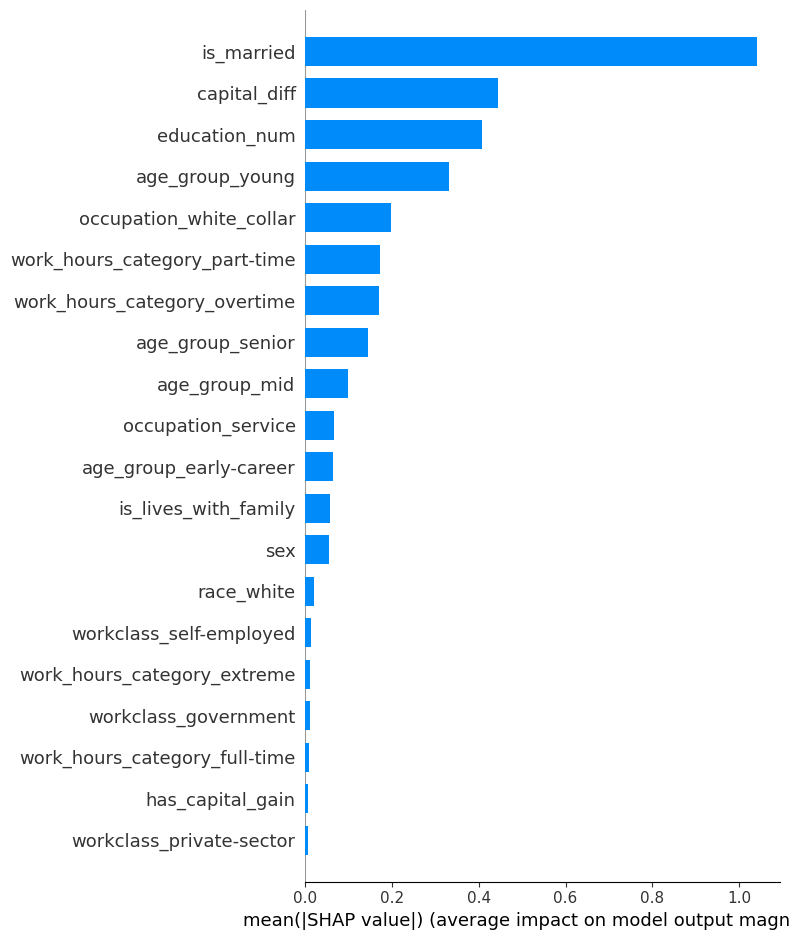

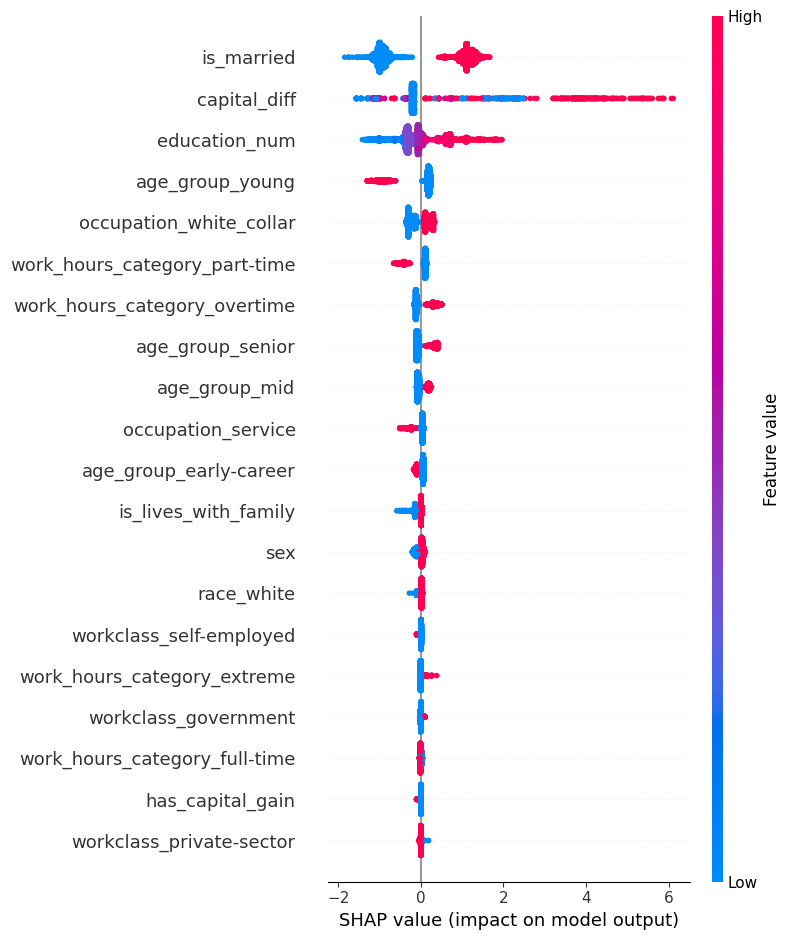

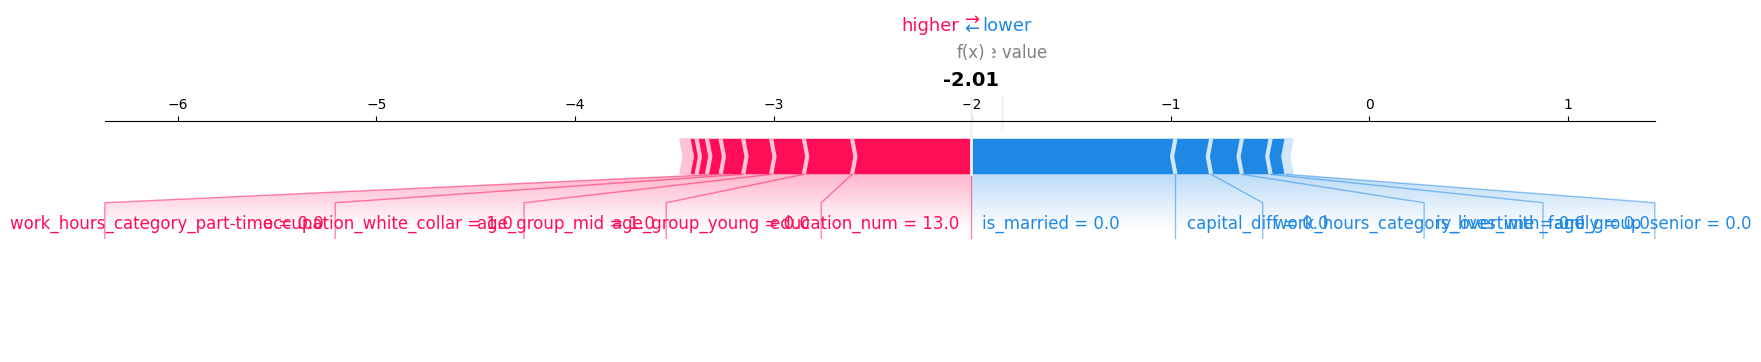

In [400]:
import shap

# Use best performing model (e.g., Random Forest or Gradient Boosting)
best_model = gb_model  

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Global importance (works without JS)
shap.summary_plot(shap_values, X_test, plot_type="bar")      # global bar
shap.summary_plot(shap_values, X_test)                       # beeswarm

# Local explanation without JS
shap.force_plot(explainer.expected_value,
                shap_values[10, :],
                X_test.iloc[10, :],
                matplotlib=True)



Permutation Importance (model-agnostic, simple)

                          Feature  Importance
2                      is_married    0.111109
4                    capital_diff    0.066168
0                   education_num    0.036277
21                age_group_young    0.013168
13        occupation_white_collar    0.007755
24               age_group_senior    0.004238
26  work_hours_category_part-time    0.004236
28   work_hours_category_overtime    0.003760
3            is_lives_with_family    0.002805
23                  age_group_mid    0.001813


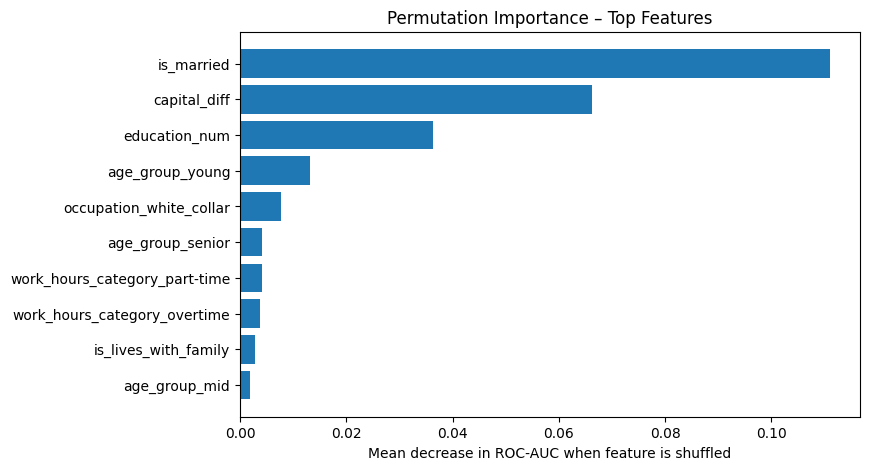

In [405]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(best_model, X_test, y_test, scoring='roc_auc', n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm.importances_mean
}).sort_values('Importance', ascending=False)

print(importance_df.head(10))
plt.figure(figsize=(8,5))
plt.barh(importance_df['Feature'][:10][::-1], importance_df['Importance'][:10][::-1])
plt.title("Permutation Importance – Top Features")
plt.xlabel("Mean decrease in ROC-AUC when feature is shuffled")
plt.show()
